# Phrases

Process the phrases that appear in a relation.

## 1. Preprocess data

In [26]:
import copy
import datetime
import json
import pandas as pd
import re

In [27]:
def read_data(file_name):
    json_data = []
    infile = open(file_name, "r")
    for line in infile:
        json_data.append(json.loads(line))
    infile.close()
    
    return json_data

In [28]:
def remove_keys(data, keys):
    for key in keys:
        if key in data:
            del(data[key])
            

def combine_data(json_data):
    combined_data = {}
    for data in json_data:
        key = f"{data['source_id']} {data['speech_id']} {data['paragraph_id']}"
        if key not in combined_data:
            combined_data[key] = copy.deepcopy(data)
        else:
            if data["data"] != combined_data[key]["data"]:
                print("equal paragraphs (key={key}) contain different texts")
            for label_data in data["label"]:
                if label_data not in combined_data[key]["label"]:
                    combined_data[key]["label"].append(label_data)
                    if combined_data[key]["label"][-1][1] > len(combined_data[key]["data"]):
                        combined_data[key]["label"][-1][1] = len(combined_data[key]["data"])
        remove_keys(combined_data[key], ["missing concept 1", "missing content relation explanation", "missing concept 2"])
    for key in combined_data:
        for label_data in combined_data[key]["label"]:
            label_data.append(combined_data[key]["data"][label_data[0]:label_data[1]])
    return combined_data

In [36]:
def tokenize_paragraph(paragraph):
    tokens = {}
    token_id = -1
    for i in range(0, len(paragraph)):
        if token_id < 0 and paragraph[i] == " ":
            next
        elif token_id < 0:
            token_id = i
            tokens[token_id] = paragraph[i]
        elif paragraph[i] == " ":
            token_id = -1
        elif re.search("[.,?!]", paragraph[i]):
            tokens[i] = paragraph[i]
        else:
            tokens[token_id] += paragraph[i]
    return tokens


def tokenize_data(combined_data):
    for data_key in combined_data:
        paragraph = combined_data[data_key]["data"]
        token = tokenize_paragraph(paragraph)
        labels = {}
        for label_key in tokens:
            labels[label_key] = "O"
        for label in combined_data[data_key]["label"]:
            if label[2] == 'Content_Concept_1' or label[2] == 'Content_Concept_2':
                for label_key in labels:
                    if label_key >= label[0] and label_key < label[1]:
                        if labels['label_key'] == "E":
                            print("overwriting label E")
                        labels[label_key] = "C"
            elif label[2] == 'Content_Relation_Explanation':
                for label_key in labels:
                    if label_key >= label[0] and label_key < label[1]:
                        if labels['label_key'] == "C":
                            print("overwriting label C")
                        labels[label_key] = "E"
        combined_data[data_key]["tokens"] = [ (tokens[label_key], labels[label_key]) for label_key in labels ]
    return combined_data

In [37]:
json_data = read_data("../data/femke-20211012.jsonl")
combined_data = combine_data(json_data)
combined_data = tokenize(combined_data)

In [31]:
print(f"data sizes: json_data: {len(json_data)}; combined_data: {len(combined_data)}")

data sizes: json_data: 1867; combined_data: 526


In [32]:
json_data[0]

{'id': 6660,
 'data': 'Today I want to send a clear message to the people of this great country, of Greece. I know that many people feel without hope. Many are making extremely difficult sacrifices. And many people ask why they should do more. I understand those concerns. And I agree that some of the efforts seem unfair. But I ask people to recognise the other alternatives which will be much more difficult for Greece and will affect even more the most vulnerable in the Greek society. So this is why it is the right approach to ask Greece to reform, to increase its competitiveness to have a viable future, irrespective of the crisis. You, in Greece, with our support, need to rebuild your country, your structures, your administration, your economy to increase the competitiveness of Greece. And the best hope of a return to growth and job creation is inside the euro area. Staying in the euro is the best chance to avoid worse hardship and difficulties to the Greek people, namely for those in 

In [33]:
combined_data[list(combined_data.keys())[0]]

{'id': 6660,
 'data': 'Today I want to send a clear message to the people of this great country, of Greece. I know that many people feel without hope. Many are making extremely difficult sacrifices. And many people ask why they should do more. I understand those concerns. And I agree that some of the efforts seem unfair. But I ask people to recognise the other alternatives which will be much more difficult for Greece and will affect even more the most vulnerable in the Greek society. So this is why it is the right approach to ask Greece to reform, to increase its competitiveness to have a viable future, irrespective of the crisis. You, in Greece, with our support, need to rebuild your country, your structures, your administration, your economy to increase the competitiveness of Greece. And the best hope of a return to growth and job creation is inside the euro area. Staying in the euro is the best chance to avoid worse hardship and difficulties to the Greek people, namely for those in 

## 2. Visualize data

In [38]:
def make_ids(labels, text):
    ids = {}
    for label_data in labels:
        while text[label_data[0]] in " .,?!:;":
            label_data[0] += 1
        while text[label_data[1]-1] in " .,?!:;":
            label_data[1] -= 1
        if label_data[0] in ids or label_data[1] in ids:
            print(f"overlapping relation parts! {data_item['label']}")
        ids[label_data[0]] = { "type": "start", "label": label_data[2] }
        ids[label_data[1]] = { "type":"end", "label": label_data[2] }
    return ids 

In [39]:
def add_colors_to_text(text, ids):
    for key in sorted(ids.keys(), reverse=True):
        if ids[key]["type"] == "end":
            text = text[:key+1] + "\x1b[m" + text[key+1:]
        else:
            if ids[key]["label"] == "Content_Concept_1":
                color_code = 1
            elif ids[key]["label"] == "Content_Concept_2":
                color_code = 4
            elif ids[key]["label"] == "Content_Relation_Explanation":
                color_code = 0
            else:
                color_code = 7
                print(f"unknown relation part label! ({ids[key]['label']})")
            text = text[:key] + f"\x1b[1;3{color_code};47m" + text[key:]
    return text    

In [40]:
def visualize(json_data, i):
    text = json_data[i-1]["data"]
    ids = make_ids(json_data[i-1]['label'], text)
    text = add_colors_to_text(text, ids)
    print(text + "\n")

In [41]:
MAX_PARAGRAPHS = 3

seen = {}
for i in range(1, len(json_data)+1):
    data_item = json_data[i - 1]
    if str(data_item["source_id"]) + " " + str(data_item["speech_id"]) in seen:
        continue
    visualize(json_data, i)
    seen[ str(data_item["source_id"]) + " " + str(data_item["speech_id"]) ] = True
    if MAX_PARAGRAPHS > 0 and len(seen) >= MAX_PARAGRAPHS:
        break

Today I want to send a clear message to the people of this great country, of Greece. I know that many people feel without hope. Many are making extremely difficult sacrifices. And many people ask why they should do more. I understand those concerns. And I agree that some of the efforts seem unfair. But I ask people to recognise the other alternatives which will be much more difficult for Greece and will affect even more the most vulnerable in the Greek society. So this is why it is the right approach to ask Greece to reform, to increase its competitiveness to have a viable future, irrespective of the crisis. You, in Greece, with our support, need to rebuild your country, your structures, your administration, your economy to increase the competitiveness of Greece. And the best hope of a return to growth and job creation is inside the euro area. Staying in the euro is the best chance to avoid worse hardship and difficulties to the Greek people, namely for those in a more vulnerable posit

In [42]:
visualize(json_data, 1397)

Before EMU, the current euro area countries followed different economic strategies. Between 1970 and 1999, unit labour costs in Germany, the Netherlands en Austria grew by a factor of 2.5 to 3. During these 28 years prior to EMU, unit labour costs grew by a factor of 12 in Italy, 14 in Spain, 35 in Portugal and 55 in Greece. By regularly devaluing their currencies, these countries were able to restore competitiveness. But after the launch of EMU, this policy option was no longer available, of course.



## 3. Check for duplicate candidate phrases

The phrases in the text were initially labeled automatically, based on lists of relevant phrases per paragraph. The labels were assigned to the first matching phrase found but when the phrase appeared several times in the paragraph, this choice could have been wrong. Therefore this part of the notebook searches for paragraph with multiple matching relevant phrases. These paragraphs were then manually checked and corrected in the Doccano annotation tool.

Difficult cases:
* 22 (This)
* 363 (ex)
* 988 (:)
* 993 (:)

In [11]:
counter = 0
for data_item in json_data:
    counter += 1
    text = data_item["data"]
    for label_data in data_item['label']:
        phrase = text[label_data[0]:label_data[1]+1]
        for i in range(0, len(text)-len(phrase)):
            if text[i:i+len(phrase)].lower() == phrase.lower() and i != label_data[0]:
                print(counter, phrase)
                break

1 to 
2 to 
3 to 
4 to 
31 markets 
35 in 
49 Eurosystem 
60 the crisis 
99 to ensure 
102 growth 
103 growth 
104 growth 
105 growth 
106 growth 
107 reforms.
108 reforms.
109 reforms.
112  it 
123 to make 
124 to make 
126 to 
127 to 
146 For 
155 strengthening 
157 strengthening 
158 to 
160 that 
161 to bring 
161  We 
162 to bring 
163 that 
176 that 
177 that 
182 we are capable of 
182 taking decisions.
209 we need to 
210 we need to 
211 we need to 
218 Member States 
219 Member States 
246 to 
247 requires 
247 Peace 
248 requires 
249 requires 
249 Peace 
250 requires 
251 requires 
252 requires 
278 crisis 
279 crisis 
289 monetary policy.
290 monetary policy.
291 monetary policy.
306 banks 
307 through 
308 monetary policy 
313 monetary policy 
315 we need to 
316 to 
318 growth 
319 growth 
320 growth 
321  growth 
322 reduce 
323 reduce 
330 based on 
331 based on 
333 fair 
335 no 
335 wage cuts 
335 package.
336 no 
336 wage cuts 
336 package.
338 growth 
341 package 
3

## 4. Find relations within one sentence

We want to use only local relations (within a single sentence) for training to make the rate of out-of-relation words smaller.

In [43]:
def sort_labels(labels):
    was_sorted = True
    for i in range(0, len(labels)-1):
        if labels[i][0] > labels[i+1][0]:
            labels[i], labels[i+1] = labels[i+1], labels[i]
            was_sorted = False
    if was_sorted: 
        return labels
    else:
        return sort_labels(labels)

This function checks for overlapping labels in the paragraphs (characters being assignedto more than one phrase). The overlapping phrases were manually resolved on 20211012, so no overlapping phrases should be found in the data.

In [44]:
def find_overlapping_labels(json_data):
    overlapping_labels_found = 0
    for j in range(0, len(json_data)):
        data_item = json_data[j]
        labels = sort_labels(data_item['label'])
        for i in range(0,len(labels)-1):
            if labels[i][1] > labels[i+1][0]:
                print(f"overlapping labels in item {j+1}")
                overlapping_labels_found += 1
    if overlapping_labels_found == 0:
        print("no overlapping labels found")
                
find_overlapping_labels(json_data)

no overlapping labels found


In [45]:
SENTENCE_BOUNDARY = '[!?.]'

def get_sentence_boundaries(text, sorted_labels):
    start = sorted_labels[0][0]
    while start-2 >= 0 and not re.search(SENTENCE_BOUNDARY, json_data[j]['data'][start-2]):
        start -= 1
    end = sorted_labels[-1][1]
    while end-1 < len(json_data[j]["data"]) and not re.search(SENTENCE_BOUNDARY, json_data[j]['data'][end-1]):
        end += 1
    return(start, end)

In [46]:
one_sentence_data = []
for j in range(0, len(json_data)):
    sorted_labels = sort_labels(json_data[j]["label"])
    if len(set([x[2] for x in sorted_labels])) < 3:
        continue
    relation_in_one_sentence = True
    for i in range(sorted_labels[0][0], sorted_labels[-1][1]):
        if re.search(SENTENCE_BOUNDARY, json_data[j]['data'][i]):
            relation_in_one_sentence = False
            break
    if relation_in_one_sentence:
        start, end = get_sentence_boundaries(json_data[j]["data"], sorted_labels)
        data_copy = copy.deepcopy(json_data[j])
        data_copy["data"] = json_data[j]["data"][start:end]
        for label in data_copy["label"]:
            label[0] -= start
            label[1] -= start
        one_sentence_data.append(data_copy)
       
print(f"found: {len(one_sentence_data)}")

found: 1138


In [47]:
visualize(one_sentence_data, 1)

You, in Greece, with our support, need to rebuild your country, your structures, your administration, your economy to increase the competitiveness of Greece.



In [48]:
combined_data_all = tokenize({i: one_sentence_data[i] for i in range(0, len(one_sentence_data))})

In [49]:
def remove_duplicate_paragraphs(combined_data_all):
    seen = {}
    combined_data = {}
    for combined_data_key in combined_data_all:
        source_key = " ".join([str(combined_data_all[combined_data_key]["source_id"]), 
                               str(combined_data_all[combined_data_key]["speech_id"]), 
                               str(combined_data_all[combined_data_key]["paragraph_id"])])
        if source_key not in seen:
            combined_data[combined_data_key] = combined_data_all[combined_data_key]
        seen[source_key] = True
    print(len(combined_data))

437


In [ ]:
remove_duplicate_paragraphs(combined_data_all)

## 5. Roberta Named Entity Recogntion by Erik Novak

Source: https://www.kaggle.com/eriknovak/pytorch-roberta-named-entity-recognition

In [50]:
import sys
!{sys.executable} -m pip install datasets

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaForTokenClassification, RobertaTokenizer
from datasets import load_dataset, Dataset, DatasetDict, Features, Value
from datasets.features import Sequence, ClassLabel
# HACK for transformers kernel: in ~/projects/filterbubble/transformers/venv3/lib/python3.7/site-packages/datasets/load.py replaced line 284: huggingface_hub.hf_api.DatasetInfo by ""
import tqdm

2021-11-19 16:28:56.491741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-19 16:28:56.491763: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [52]:
tqdmn = tqdm.notebook.tqdm
roberta_version = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(roberta_version)

In [53]:
def make_project_data(combined_data):
    project_data = { 'id': [], 'tokens': [], 'ner_tags': [] }
    ner_tag_ids = { 'O': 0 }
    for key in combined_data:
        tokens = []
        ner_tags = [ 0 ]
        for i in range(0, len(combined_data[key]['tokens'])):
            if combined_data[key]['tokens'][i][1] not in ner_tag_ids:
                ner_tag_ids[combined_data[key]['tokens'][i][1]] =  len(ner_tag_ids)
            tokens.append(combined_data[key]['tokens'][i][0])
            ner_tags.append(ner_tag_ids[combined_data[key]['tokens'][i][1]])
        project_data['id'].append(str(len(project_data['id'])))
        project_data['tokens'].append(tokens)
        project_data['ner_tags'].append(ner_tags)
    return project_data, ner_tag_ids

In [54]:
def add_encodings(example):
    encodings = tokenizer(example['tokens'], truncation=True, padding='max_length', is_split_into_words=True)
    labels = example['ner_tags'] + [0] * (tokenizer.model_max_length - len(example['ner_tags']))
    return { **encodings, 'labels': labels }

In [55]:
def convert_project_data(project_data, ner_tag_ids):
    features_id = Value('string')
    features_tokens = Sequence(Value('string'))
    features_ner_tags = Sequence(ClassLabel(names=list(ner_tag_ids.keys())))
    features = Features({"id": features_id, "tokens": features_tokens, "ner_tags": features_ner_tags })
    project_data_converted = DatasetDict({ "train": Dataset.from_dict(project_data, features=features)} )
    num_labels = project_data_converted["train"].features['ner_tags'].feature.num_classes
    project_data_converted = project_data_converted.map(add_encodings)
    return project_data_converted, num_labels

In [56]:
project_data, ner_tag_ids = make_project_data(combined_data)
project_data_converted, num_labels = convert_project_data(project_data, ner_tag_ids)
project_data_converted.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [57]:
labels = project_data_converted['train'].features['ner_tags'].feature
label2id = { k: labels.str2int(k) for k in labels.names }
id2label = { v: k for k, v in label2id.items() }

In [61]:
model = RobertaForTokenClassification.from_pretrained(roberta_version, num_labels=num_labels)
model.config.id2label = id2label
model.config.label2id = label2id
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.train().to(device)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)
n_epochs = 2
train_data = torch.utils.data.DataLoader(project_data_converted['train'], batch_size=4)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [59]:
def train(train_data, model, device, optimizer, n_epochs):
    train_loss = []
    today = datetime.date.today().strftime("%Y%m%d")
    for epoch in tqdmn(range(n_epochs)):
        current_loss = 0
        for i, batch in enumerate(tqdmn(train_data)):
            batch = { k: v.to(device) for k, v in batch.items() }
            outputs = model(**batch)
            loss = outputs[0]
            loss.backward()
            current_loss += loss.item()
            if i % 8 == 0 and i > 0:
                optimizer.step()
                optimizer.zero_grad()
                train_loss.append(current_loss / 32)
                current_loss = 0
        optimizer.step()
        optimizer.zero_grad()
        model.save_pretrained(f"models/{today}_{epoch}")
    return train_loss

In [62]:
train_loss = train(train_data, model, device, optimizer, n_epochs)

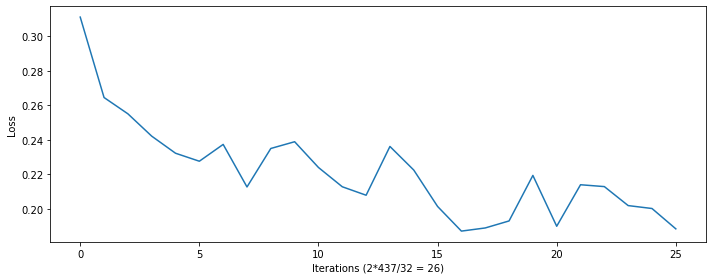

In [63]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(train_loss)
ax.set_ylabel('Loss')
ax.set_xlabel(f'Iterations ({n_epochs}*{len(combined_data)}/32 = {n_epochs*int(len(combined_data)/32)})')
fig.tight_layout()
plt.show()

In [64]:
model = model.eval()
test_data = torch.utils.data.DataLoader(project_data_converted['train'], batch_size=4)

In [65]:
def validate(test_data, model, device, num_labels):
    validation_results = []
    for i, batch in enumerate(tqdmn(test_data)):
        with torch.no_grad():
            batch = { k: v.to(device) for k, v in batch.items() }
            outputs = model(**batch)
        s_lengths = batch['attention_mask'].sum(dim=1)
        for idx, length in enumerate(s_lengths):
            true_values = batch['labels'][idx][:length]
            pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
            for true, pred in zip(true_values, pred_values):
                validation_results.append((true.item(), pred.item()))
    return validation_results


def count_validation_results(validation_results, null_element=0):
    confusion = torch.zeros(num_labels, num_labels)
    found = 0
    missed = 0
    wrong = 0
    for true, pred in validation_results:
        confusion[true][pred] += 1
        if true != null_element:
            if pred == true:
                found += 1
            else: 
                missed += 1
        elif pred != null_element:
            wrong += 1
    return confusion, found, missed, wrong

In [66]:
def read_model(directory):
    model = RobertaForTokenClassification.from_pretrained(roberta_version, num_labels=num_labels)
    model.config.id2label = id2label
    model.config.label2id = label2id
    model.train().to(device)
    model.from_pretrained(directory)
    model = model.eval()
    return model

#model = read_model("models/20211025_0")
#confusion, found, missed, wrong = validate(test_data, model, device, num_labels)

In [67]:
validation_results = validate(test_data, model, device, num_labels)

In [68]:
confusion, found, missed, wrong = count_validation_results(validation_results, null_element=0)

In [73]:
if found + wrong == 0:
    precision = 0.0
else:
    precision = found / (found + wrong)
recall = found / (found + missed)
f1 = 2 * precision * recall / (precision + recall)

print(f"precision: {precision:.3f}; recall: {recall:.3f}; f1: {f1:.3f}")

precision: 0.698; recall: 0.212; f1: 0.325


In [70]:
for i in range(num_labels):
    confusion[i] = confusion[i] / confusion[i].sum()

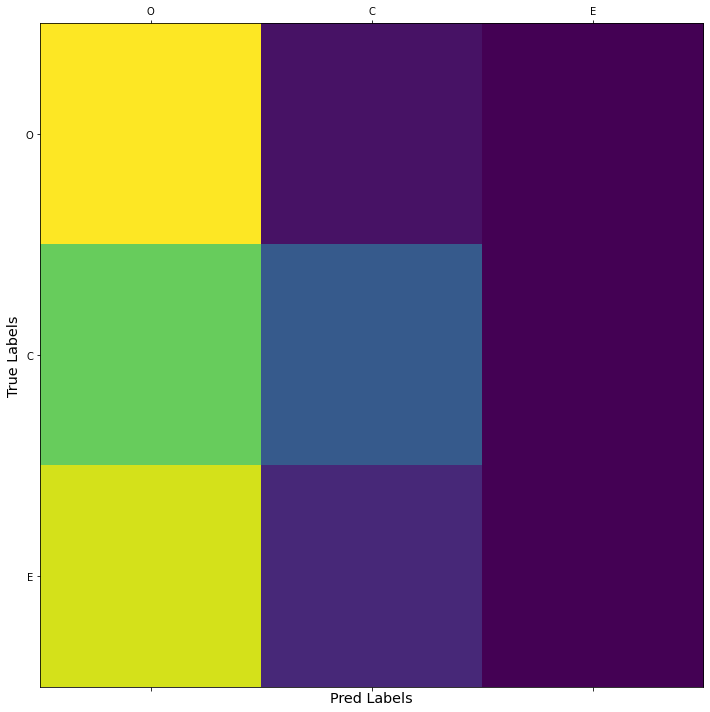

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confusion.numpy())

labels = list(label2id.keys())
ids = np.arange(len(labels))

ax.set_ylabel('True Labels', fontsize='x-large')
ax.set_xlabel('Pred Labels', fontsize='x-large')

ax.set_xticks(ids)
ax.set_xticklabels(labels)

ax.set_yticks(ids)
ax.set_yticklabels(labels)

fig.tight_layout()
plt.show()

In [72]:
confusion.numpy()

array([[0.9519659 , 0.04803409, 0.        ],
       [0.7320216 , 0.26797846, 0.        ],
       [0.88987565, 0.11012433, 0.        ]], dtype=float32)

## 6. Visualize BERT output

Data preferences of the machine learning process:

* consistency: similar input requires similar output
* use local context: it is easier to pay attention to this than to remote context
* process linguistic entities: they can be pre-identified with other tools

In [74]:
type(validation_results)

list

In [75]:
len(validation_results)

15721

In [ ]:
for project_data_id in range(0, len(project_data_converted["train"])):
    

In [76]:
type(test_data)

torch.utils.data.dataloader.DataLoader

In [77]:
validation_results[0:32]

[(0, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 1),
 (1, 0),
 (1, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (2, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (0, 0),
 (0, 0)]

In [78]:
for i in range(0, len(project_data["tokens"][0])):
    print(project_data["ner_tags"][0][i], project_data["tokens"][0][i])

0 You
1 ,
1 in
1 Greece
1 ,
1 with
1 our
1 support
1 ,
1 need
1 to
1 rebuild
1 your
1 country
1 ,
0 your
0 structures
0 ,
0 your
0 administration
0 ,
0 your
0 economy
0 to
2 increase
1 the
1 competitiveness
1 of
1 Greece
1 .


In [82]:
project_data_converted["train"][0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0

In [89]:
PAD_TOKEN = 1
example = project_data_converted["train"][0]
validation_results_id = 0

for project_data_id in range(0, 3): # len(project_data_converted["train"])):
    example = project_data_converted["train"][project_data_id]
    for i in range(0, len(example["input_ids"])):
        if example["input_ids"][i] != PAD_TOKEN:
            token = re.sub("^ *", "", tokenizer.decode(example["input_ids"][i:i+1]))
            label = example["labels"][i:i+1].item()
            print(validation_results[validation_results_id][1], label, token)
            validation_results_id += 1

0 0 <s>
0 1 You
0 1 ,
0 1 in
0 1 Greece
0 1 ,
0 1 with
0 1 our
0 1 support
0 1 ,
0 1 need
0 1 to
1 1 rebuild
0 1 your
0 1 country
0 0 ,
0 0 your
0 0 structures
0 0 ,
0 0 your
0 0 administration
0 0 ,
0 0 your
0 0 economy
0 2 to
0 1 increase
0 1 the
0 1 competitiveness
0 1 of
0 1 Greece
0 0 .
0 0 </s>
0 0 <s>
0 1 We
0 1 have
0 1 taken
0 1 important
0 1 ,
0 1 fundamental
0 1 decisions
0 0 over
0 0 the
0 0 last
0 0 couple
0 0 of
0 0 months
0 2 to
1 2 safeguard
0 1 the
0 1 stability
0 1 of
0 1 the
0 1 euro
0 1 area
0 0 ,
0 0 and
0 0 indeed
0 0 we
0 0 are
0 0 now
0 0 in
0 0 the
0 0 phase
0 0 of
0 0 implementation
0 0 .
0 0 </s>
0 0 <s>
0 0 
0 0 iving
0 0 to
0 0 the
0 0 ECB
0 0 the
0 0 ultimate
0 0 responsibility
0 0 for
0 0 supervision
0 0 of
0 0 banks
0 0 in
0 0 the
0 0 euro
0 0 area
0 0 will
0 0 decisively
0 0 contribute
0 0 to
0 1 increase
0 1 confidence
0 1 between
0 1 the
0 2 banks
0 2 and
0 2 in
0 2 this
0 1 way
0 1 increase
0 1 the
0 1 financial
0 1 stability
0 1 in
0 1 the
0 1 euro
